In [2]:
import torch
import torch.nn as nn
from torch import tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import scipy

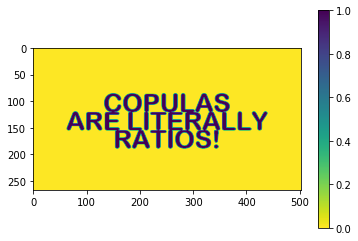

In [3]:
import matplotlib.image as mpimg

img=mpimg.imread('copula_equals_ratio.png')#'emily1.jpg')#
# convert to grayscale
img = np.mean(img, axis=2)
img = np.log(1e-2 +img / 6.0)
# rescale to 0,1
img = (img - np.min(img)) / (np.max(img) - np.min(img))
img = np.abs(img - 1.0)
#img = img[:400,:450]
plt.imshow(img, cmap='viridis_r')
plt.colorbar()

In [4]:
class ratio(nn.Module):
    def __init__(self, in_size=2, middle_size=100, layers=2, out_size=1):
        self.in_size = in_size
        self.middle_size = middle_size
        self.layers = layers
        self.out_size = out_size
        super(ratio, self).__init__()
        self.fc_in = nn.Linear(in_size, middle_size)
        self.fc_mid = nn.Linear(middle_size, middle_size)
        self.fc_out = nn.Linear(middle_size, out_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc_in(x)
        x = self.sigmoid(x)
        for l in range(self.layers):
            x = self.fc_mid(x)
            x = self.sigmoid(x)
        x = self.fc_out(x)
        return torch.exp(x)
    
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifierv2(nn.Module):
  """
  simple MLP classifier (e.g. for classifying in z-space)
  slightly deeper than MLPClassifier
  """
  def __init__(self, h_dim=100, in_dim=2):
      super(MLPClassifierv2, self).__init__()
      self.h_dim = h_dim
      self.in_dim = in_dim

      self.fc1 = nn.Linear(self.in_dim, self.h_dim)
      self.fc2 = nn.Linear(self.h_dim, self.h_dim)
      self.fc3 = nn.Linear(self.h_dim, self.h_dim)
      self.fc4 = nn.Linear(self.h_dim, self.h_dim)
      self.fc5 = nn.Linear(self.h_dim, 1)

  def forward(self, x):
    x1 = F.gelu(self.fc1(x)) 
    x2 = F.gelu(self.fc2(x1)) + x1
    x3 = F.gelu(self.fc3(x2)) + x2
    x4 = F.gelu(self.fc4(x3)) + x3
    logits = self.fc5(x4).exp()

    return logits
  


    

(ratio(2,10,2,1).forward(tt([1., 2.])),
 MLPClassifierv2(10,2).forward(tt([1., 2.])))

(tensor([0.6305], grad_fn=<ExpBackward0>),
 tensor([2.1807], grad_fn=<ExpBackward0>))

In [6]:
X_.shape

(580, 600)

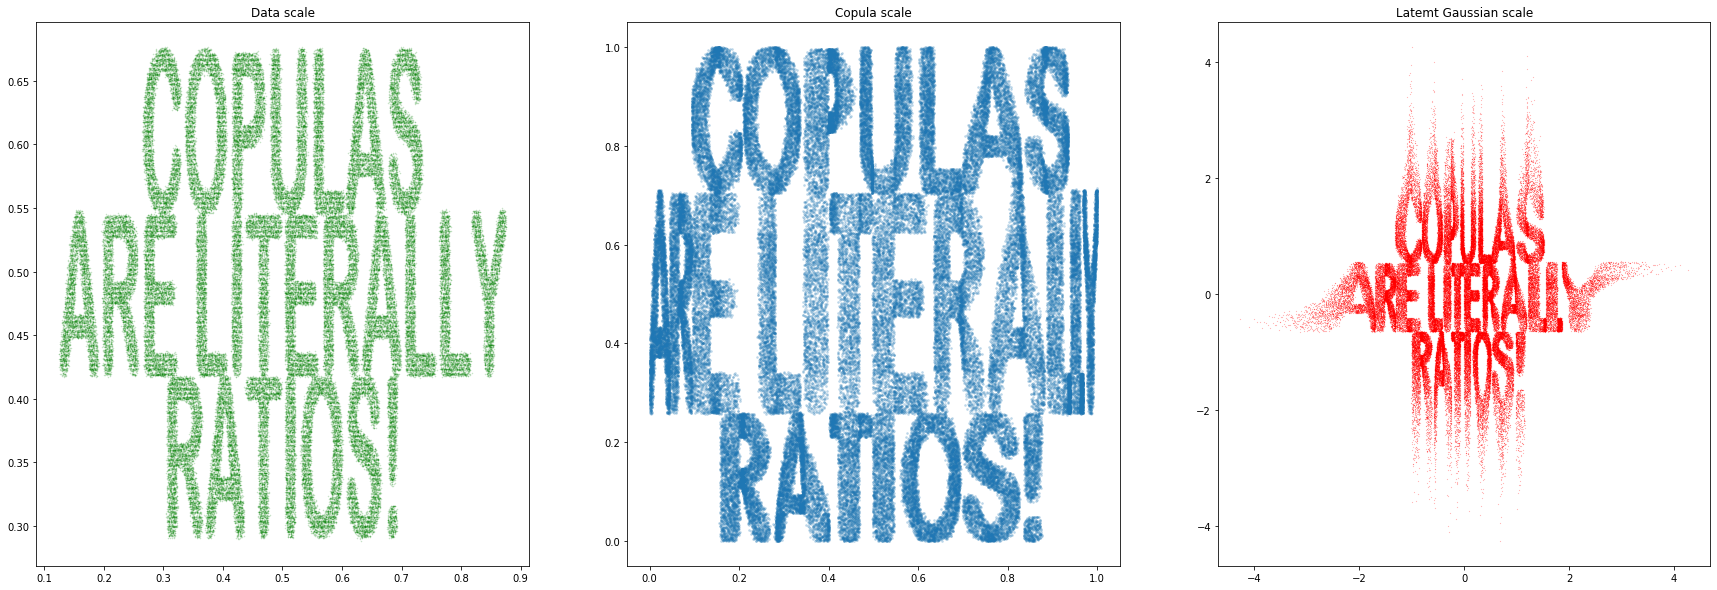

In [5]:
img_probs = img/ np.sum(img)
sample_idx = np.random.choice(np.arange(img_probs.flatten().shape[0]), size=100000,  p=img_probs.flatten())
x = np.linspace(0, 1, img.shape[1])
y = np.linspace(1, 0, img.shape[0])
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()
X = X[sample_idx]
Y = Y[sample_idx]

'''x_ = np.random.uniform(0.25, 0.75, int(img.shape[1]/5))
y_ = np.random.uniform(0.25, 0.75, int(img.shape[0]/5))
X_, Y_ = np.meshgrid(x_, y_)
X = np.append(X, X_)
Y = np.append(Y, Y_)
'''

data_p = np.stack([X, Y], axis=1) + np.random.normal(0, 0.001, (X.shape[0], 2))

'''# chessboard
data_p1 = np.concatenate((np.random.uniform(0, 1, (5000, 1)), np.random.uniform(0, 1, (5000, 1))), axis=1)
data_p2 = np.concatenate((np.random.uniform(-1, 0, (5000, 1)), np.random.uniform(-1, 0, (5000, 1))), axis=1)
data_p3 = np.concatenate((np.random.uniform(1, 2, (5000, 1)), np.random.uniform(-1, 0, (5000, 1))), axis=1)
data_p4 = np.concatenate((np.random.uniform(-1, 0, (5000, 1)), np.random.uniform(1, 2, (5000, 1))), axis=1)
data_p5 = np.concatenate((np.random.uniform(1, 2, (5000, 1)), np.random.uniform(1, 2, (5000, 1))), axis=1)
#combine the two datasets
data_p = np.concatenate((data_p1, data_p2,data_p3,data_p4,data_p5), axis=0)
'''

from statsmodels.distributions.empirical_distribution import ECDF

cdf_1 = ECDF(data_p[:,0])
cdf_2 = ECDF(data_p[:,1])

from scipy.interpolate import interp1d

slope_changes = sorted(set(data_p[:,0]))

sample_edf_values_at_slope_changes1 = [ cdf_1(item) for item in slope_changes]
sample_edf_values_at_slope_changes2 = [ cdf_2(item) for item in slope_changes]

inverted_cdf1 = interp1d(sample_edf_values_at_slope_changes1, slope_changes)
inverted_cdf2 = interp1d(sample_edf_values_at_slope_changes2, slope_changes)


u = cdf_1(data_p[:,0])
v = cdf_2(data_p[:,1])

z1 = scipy.stats.norm.ppf(u)
z2 = scipy.stats.norm.ppf(v)
z = np.stack([z1, z2], axis=1)

# do a 3 subplot
fig, ax = plt.subplots(1,3, figsize=(30,10))
ax[0].scatter(data_p[:,0],data_p[:,1],s=0.3,c='green',alpha=0.2)
ax[1].scatter(u,v, s=3, alpha=0.2)
ax[2].scatter(z1,z2, s=0.01, c='red')
# titles for each
ax[0].set_title('Data scale')
ax[1].set_title('Copula scale')
ax[2].set_title('Latemt Gaussian scale')

plt.show()

In [9]:
# train ratio copula
from Ratio import Ratio
from Ratio import loss_nce
from tqdm import tqdm

u1, u2 = u,v

q_data = np.random.randn(5000,2)
ratio = Ratio(h_dim=100, in_dim=2, h_layers=5)

optimizer = torch.optim.Adam(ratio.parameters(), lr= 0.002)
z[z==np.inf] = 0

    
for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    r_p = ratio(tt(z[np.random.choice(range(z.shape[0]),size=5000)]).float())
    r_q = ratio(tt(q_data).float())
    #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
    loss = loss_nce(r_p, r_q, 5000, q_data.shape[0])
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            print(f'Epoch {epoch}, loss {loss.item()}')

model = ratio

  0%|          | 2/10000 [00:00<37:11,  4.48it/s]

Epoch 0, loss 1.5442951917648315


  1%|          | 102/10000 [00:12<18:22,  8.98it/s]

Epoch 100, loss 1.2996336221694946


  2%|▏         | 202/10000 [00:23<16:09, 10.11it/s]

Epoch 200, loss 1.280580759048462


  3%|▎         | 303/10000 [00:36<16:15,  9.94it/s]

Epoch 300, loss 1.268740177154541


  4%|▍         | 403/10000 [00:46<15:00, 10.66it/s]

Epoch 400, loss 1.2586867809295654


  5%|▌         | 502/10000 [00:56<19:16,  8.21it/s]

Epoch 500, loss 1.262631893157959


  6%|▌         | 602/10000 [01:07<33:14,  4.71it/s]

Epoch 600, loss 1.252535343170166


  7%|▋         | 702/10000 [01:18<15:24, 10.06it/s]

Epoch 700, loss 1.2435917854309082


  8%|▊         | 802/10000 [01:29<14:42, 10.42it/s]

Epoch 800, loss 1.2431179285049438


  9%|▉         | 902/10000 [01:43<17:09,  8.84it/s]

Epoch 900, loss 1.2346749305725098


 10%|█         | 1000/10000 [01:54<14:34, 10.30it/s]

Epoch 1000, loss 1.2436292171478271


 11%|█         | 1103/10000 [02:12<15:53,  9.33it/s]

Epoch 1100, loss 1.2232050895690918


 12%|█▏        | 1202/10000 [02:23<26:07,  5.61it/s]

Epoch 1200, loss 1.2208845615386963


 13%|█▎        | 1303/10000 [02:34<14:25, 10.05it/s]

Epoch 1300, loss 1.2270290851593018


 14%|█▍        | 1402/10000 [02:51<21:07,  6.78it/s]

Epoch 1400, loss 1.2052059173583984


 15%|█▌        | 1502/10000 [03:04<16:04,  8.81it/s]

Epoch 1500, loss 1.2001206874847412


 16%|█▌        | 1602/10000 [03:15<16:04,  8.71it/s]

Epoch 1600, loss 1.20243501663208


 17%|█▋        | 1702/10000 [03:26<15:07,  9.14it/s]

Epoch 1700, loss 1.1877503395080566


 18%|█▊        | 1802/10000 [03:37<14:02,  9.74it/s]

Epoch 1800, loss 1.201672077178955


 19%|█▉        | 1902/10000 [03:51<15:01,  8.98it/s]

Epoch 1900, loss 1.2136421203613281


 20%|██        | 2002/10000 [04:02<13:45,  9.68it/s]

Epoch 2000, loss 1.192244291305542


 21%|██        | 2102/10000 [04:12<14:38,  8.99it/s]

Epoch 2100, loss 1.1826448440551758


 22%|██▏       | 2202/10000 [04:23<13:10,  9.87it/s]

Epoch 2200, loss 1.1818695068359375


 23%|██▎       | 2302/10000 [04:34<14:25,  8.90it/s]

Epoch 2300, loss 1.1839189529418945


 24%|██▍       | 2401/10000 [04:45<15:00,  8.44it/s]

Epoch 2400, loss 1.1854171752929688


 25%|██▌       | 2502/10000 [04:56<15:02,  8.31it/s]

Epoch 2500, loss 1.1710097789764404


 26%|██▌       | 2602/10000 [05:13<20:32,  6.00it/s]

Epoch 2600, loss 1.1656153202056885


 27%|██▋       | 2703/10000 [05:25<12:15,  9.92it/s]

Epoch 2700, loss 1.1658514738082886


 28%|██▊       | 2802/10000 [05:38<17:43,  6.77it/s]

Epoch 2800, loss 1.1664323806762695


 29%|██▉       | 2902/10000 [05:49<11:37, 10.17it/s]

Epoch 2900, loss 1.1711690425872803


 30%|███       | 3002/10000 [05:59<12:19,  9.47it/s]

Epoch 3000, loss 1.1591954231262207


 31%|███       | 3103/10000 [06:09<11:23, 10.09it/s]

Epoch 3100, loss 1.162256121635437


 32%|███▏      | 3202/10000 [06:19<11:41,  9.69it/s]

Epoch 3200, loss 1.1567294597625732


 33%|███▎      | 3303/10000 [06:29<10:56, 10.19it/s]

Epoch 3300, loss 1.1569744348526


 34%|███▍      | 3402/10000 [06:39<10:55, 10.07it/s]

Epoch 3400, loss 1.1502737998962402


 35%|███▌      | 3502/10000 [06:50<10:53,  9.94it/s]

Epoch 3500, loss 1.1532915830612183


 36%|███▌      | 3602/10000 [07:00<10:56,  9.75it/s]

Epoch 3600, loss 1.1699100732803345


 37%|███▋      | 3702/10000 [07:11<11:39,  9.01it/s]

Epoch 3700, loss 1.1544804573059082


 38%|███▊      | 3802/10000 [07:23<11:36,  8.90it/s]

Epoch 3800, loss 1.148665428161621


 39%|███▉      | 3902/10000 [07:35<11:27,  8.87it/s]

Epoch 3900, loss 1.1439319849014282


 40%|████      | 4003/10000 [07:47<10:24,  9.61it/s]

Epoch 4000, loss 1.140352487564087


 41%|████      | 4102/10000 [07:59<10:34,  9.29it/s]

Epoch 4100, loss 1.1623358726501465


 42%|████▏     | 4202/10000 [08:10<11:22,  8.50it/s]

Epoch 4200, loss 1.1577048301696777


 43%|████▎     | 4302/10000 [08:23<12:41,  7.49it/s]

Epoch 4300, loss 1.1331322193145752


 44%|████▍     | 4402/10000 [08:34<09:57,  9.36it/s]

Epoch 4400, loss 1.152639627456665


 45%|████▌     | 4502/10000 [08:45<10:21,  8.85it/s]

Epoch 4500, loss 1.150113582611084


 46%|████▌     | 4602/10000 [08:56<10:03,  8.95it/s]

Epoch 4600, loss 1.2016663551330566


 47%|████▋     | 4702/10000 [09:07<11:48,  7.48it/s]

Epoch 4700, loss 1.1400225162506104


 48%|████▊     | 4802/10000 [09:19<10:18,  8.40it/s]

Epoch 4800, loss 1.2093600034713745


 49%|████▉     | 4902/10000 [09:31<13:05,  6.49it/s]

Epoch 4900, loss 1.1398323774337769


 50%|█████     | 5001/10000 [09:42<08:38,  9.64it/s]

Epoch 5000, loss 1.2072490453720093


 51%|█████     | 5102/10000 [09:54<10:54,  7.48it/s]

Epoch 5100, loss 1.1481664180755615


 52%|█████▏    | 5202/10000 [10:08<10:12,  7.83it/s]

Epoch 5200, loss 1.13016939163208


 53%|█████▎    | 5302/10000 [10:20<08:31,  9.19it/s]

Epoch 5300, loss 1.1246085166931152


 54%|█████▍    | 5402/10000 [10:33<08:09,  9.39it/s]

Epoch 5400, loss 1.1477800607681274


 55%|█████▌    | 5501/10000 [10:43<07:19, 10.23it/s]

Epoch 5500, loss 1.117704153060913


 56%|█████▌    | 5602/10000 [10:55<08:08,  9.00it/s]

Epoch 5600, loss 1.1462526321411133


 57%|█████▋    | 5702/10000 [11:06<08:30,  8.43it/s]

Epoch 5700, loss 1.1439518928527832


 58%|█████▊    | 5802/10000 [11:19<07:30,  9.31it/s]

Epoch 5800, loss 1.1205897331237793


 59%|█████▉    | 5902/10000 [11:29<07:18,  9.36it/s]

Epoch 5900, loss 1.1192697286605835


 60%|██████    | 6002/10000 [11:42<08:45,  7.61it/s]

Epoch 6000, loss 1.164541482925415


 61%|██████    | 6102/10000 [11:53<07:28,  8.68it/s]

Epoch 6100, loss 1.1351571083068848


 62%|██████▏   | 6203/10000 [12:03<06:08, 10.29it/s]

Epoch 6200, loss 1.1386431455612183


 63%|██████▎   | 6302/10000 [12:15<07:01,  8.77it/s]

Epoch 6300, loss 1.124902367591858


 64%|██████▍   | 6403/10000 [12:26<06:03,  9.89it/s]

Epoch 6400, loss 1.1374951601028442


 65%|██████▌   | 6502/10000 [12:37<05:30, 10.58it/s]

Epoch 6500, loss 1.096118450164795


 66%|██████▌   | 6602/10000 [12:48<06:26,  8.79it/s]

Epoch 6600, loss 1.114041805267334


 67%|██████▋   | 6702/10000 [13:00<06:01,  9.13it/s]

Epoch 6700, loss 1.1086349487304688


 68%|██████▊   | 6802/10000 [13:12<06:04,  8.77it/s]

Epoch 6800, loss 1.1182138919830322


 69%|██████▉   | 6902/10000 [13:24<06:36,  7.82it/s]

Epoch 6900, loss 1.1244457960128784


 70%|███████   | 7002/10000 [13:35<05:25,  9.21it/s]

Epoch 7000, loss 1.11134934425354


 71%|███████   | 7103/10000 [13:46<04:43, 10.21it/s]

Epoch 7100, loss 1.1249704360961914


 72%|███████▏  | 7203/10000 [13:56<04:35, 10.15it/s]

Epoch 7200, loss 1.1134412288665771


 73%|███████▎  | 7302/10000 [14:06<04:30,  9.99it/s]

Epoch 7300, loss 1.1076995134353638


 74%|███████▍  | 7402/10000 [14:15<04:02, 10.70it/s]

Epoch 7400, loss 1.1091108322143555


 75%|███████▌  | 7502/10000 [14:27<05:00,  8.32it/s]

Epoch 7500, loss 1.1152033805847168


 76%|███████▌  | 7602/10000 [14:38<04:33,  8.78it/s]

Epoch 7600, loss 1.1169923543930054


 77%|███████▋  | 7703/10000 [14:50<03:46, 10.13it/s]

Epoch 7700, loss 1.1013169288635254


 78%|███████▊  | 7802/10000 [15:01<04:16,  8.56it/s]

Epoch 7800, loss 1.1131036281585693


 79%|███████▉  | 7902/10000 [15:14<04:56,  7.08it/s]

Epoch 7900, loss 1.1208209991455078


 80%|████████  | 8003/10000 [15:25<03:27,  9.61it/s]

Epoch 8000, loss 1.1503735780715942


 81%|████████  | 8102/10000 [15:35<03:36,  8.76it/s]

Epoch 8100, loss 1.1050176620483398


 82%|████████▏ | 8202/10000 [15:48<03:31,  8.49it/s]

Epoch 8200, loss 1.0996556282043457


 83%|████████▎ | 8303/10000 [16:00<02:48, 10.05it/s]

Epoch 8300, loss 1.1124643087387085


 84%|████████▍ | 8402/10000 [16:11<04:00,  6.65it/s]

Epoch 8400, loss 1.105250358581543


 85%|████████▌ | 8502/10000 [16:23<02:54,  8.57it/s]

Epoch 8500, loss 1.0957591533660889


 86%|████████▌ | 8602/10000 [16:34<02:34,  9.04it/s]

Epoch 8600, loss 1.0891070365905762


 87%|████████▋ | 8702/10000 [16:45<02:44,  7.91it/s]

Epoch 8700, loss 1.1273295879364014


 88%|████████▊ | 8802/10000 [16:57<02:43,  7.33it/s]

Epoch 8800, loss 1.0927743911743164


 89%|████████▉ | 8902/10000 [17:12<02:45,  6.65it/s]

Epoch 8900, loss 1.147271990776062


 90%|█████████ | 9002/10000 [17:25<01:49,  9.12it/s]

Epoch 9000, loss 1.0995358228683472


 91%|█████████ | 9102/10000 [17:37<01:39,  9.06it/s]

Epoch 9100, loss 1.1029961109161377


 92%|█████████▏| 9202/10000 [17:48<01:23,  9.59it/s]

Epoch 9200, loss 1.100959300994873


 93%|█████████▎| 9302/10000 [17:59<01:21,  8.60it/s]

Epoch 9300, loss 1.095884084701538


 94%|█████████▍| 9402/10000 [18:11<01:08,  8.74it/s]

Epoch 9400, loss 1.0822539329528809


 95%|█████████▌| 9502/10000 [18:23<01:03,  7.83it/s]

Epoch 9500, loss 1.130955457687378


 96%|█████████▌| 9602/10000 [18:34<00:46,  8.57it/s]

Epoch 9600, loss 1.0946416854858398


 97%|█████████▋| 9702/10000 [18:46<00:32,  9.15it/s]

Epoch 9700, loss 1.0768415927886963


 98%|█████████▊| 9802/10000 [18:57<00:22,  8.78it/s]

Epoch 9800, loss 1.0951074361801147


 99%|█████████▉| 9902/10000 [19:09<00:11,  8.82it/s]

Epoch 9900, loss 1.082411766052246


100%|██████████| 10000/10000 [19:20<00:00,  8.62it/s]


In [14]:
model = ratio

In [13]:
#train mlp
from tqdm import tqdm
z[z==np.inf] = 0
model = MLPClassifierv2(100,2)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.005, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=0, last_epoch=-1, verbose=False)

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

data_batch = 3000
indep_batch = 3000

for epoch in tqdm(range(20000)):
    optimizer.zero_grad()
    r_p = model(tt(z[np.random.choice(range(z.shape[0]),size=data_batch)]).float())
    r_q = model(tt(np.random.randn(indep_batch,2)).float())
    #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
    loss = loss_nce(r_p, r_q, data_batch, indep_batch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            print(f'Epoch {epoch}, loss {loss.item()}, grad {model.fc1.weight.grad.abs().median().item()}')
    


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 3/20000 [00:00<28:51, 11.55it/s]

Epoch 0, loss 1.403144359588623, grad 0.0015549995005130768


  0%|          | 69/20000 [00:04<23:36, 14.07it/s]


KeyboardInterrupt: 

In [20]:
model(tt([0.8,0.1]))

tensor([0.3629], grad_fn=<ExpBackward0>)

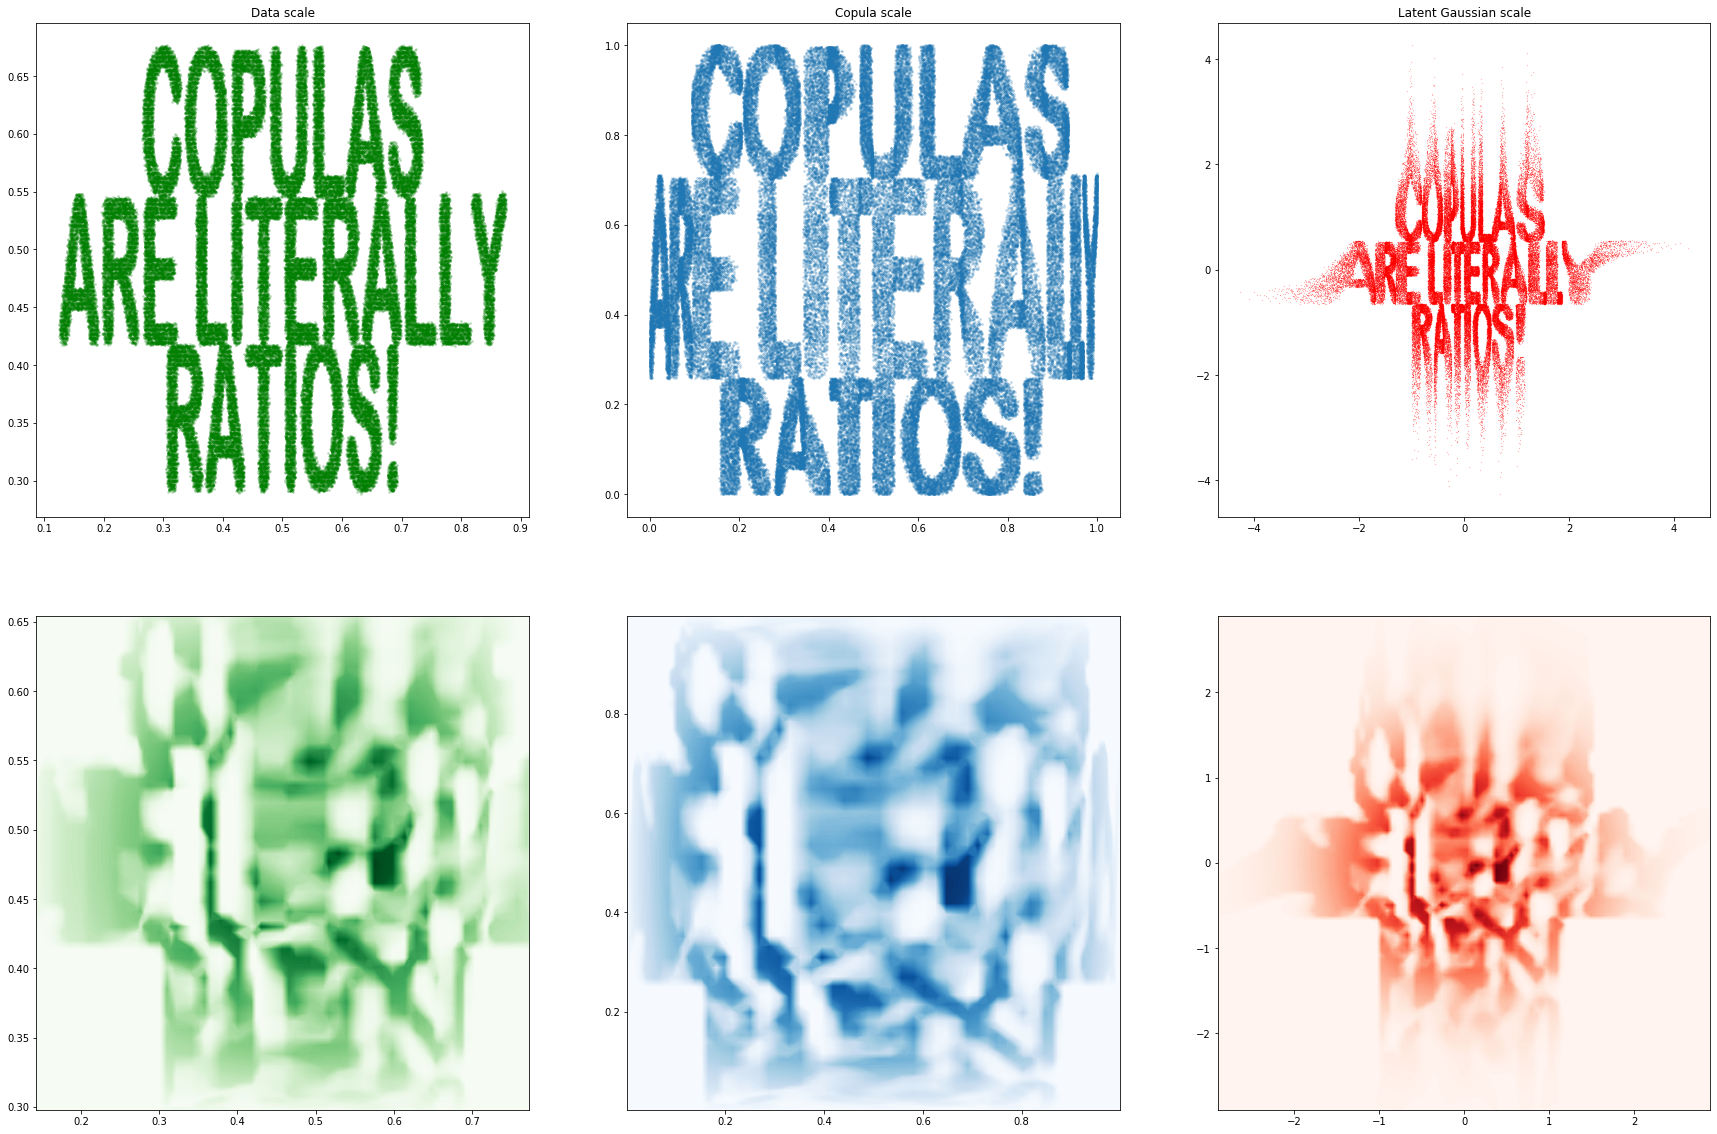

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

meshgrid = np.meshgrid(np.linspace(-2.9,2.9,100), np.linspace(-2.9,2.9,100))

ratio_grid = model(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).detach().numpy() # 1000x1000
gauss = torch.distributions.MultivariateNormal(tt([0.,0.]), tt([[1.,0.],[0.,1.]])).log_prob(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).exp().reshape(-1,1).detach().numpy()
    
ratio_grid = np.clip(ratio_grid, a_min=0.01, a_max=1.5)
# Adjust the subplot configuration to 2 rows by 3 columns
fig, ax = plt.subplots(2, 3, figsize=(30, 20))  # Adjusted for 6 plots

# Original scatter plots

ax[0, 0].scatter(data_p[:,0], data_p[:,1], s=3, c='green', alpha=0.2)
ax[0, 1].scatter(u, v, s=3, alpha=0.2)
#ax[0, 2].scatter(scs.norm.rvs(size=10000), scs.norm.rvs(size=10000), s=1, c='black')
ax[0, 2].scatter(z1, z2, s=0.01, c='red')

# Titles for each scatter plot
ax[0, 0].set_title('Data scale')
ax[0, 1].set_title('Copula scale')
ax[0, 2].set_title('Latent Gaussian scale')

# Original contour plots with colorbars
in_1 = np.clip(scs.norm.cdf(meshgrid[0]),a_max=0.95,a_min=0.01)
in_2 = np.clip(scs.norm.cdf(meshgrid[1]),a_max=0.95,a_min=0.01)

contour_set = ax[1, 0].contourf(inverted_cdf1(in_1),inverted_cdf2(in_2), (gauss* ratio_grid).reshape(100, 100),levels=100,cmap='Greens')
contour_set = ax[1, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), (gauss*ratio_grid).reshape(100, 100),levels=100,cmap='Blues')
contour_set = ax[1, 2].contourf(meshgrid[0], meshgrid[1], (gauss*ratio_grid).reshape(100, 100),levels=100,cmap='Reds')


Text(0.5, 1.0, 'Latent Gaussian scale with contours')

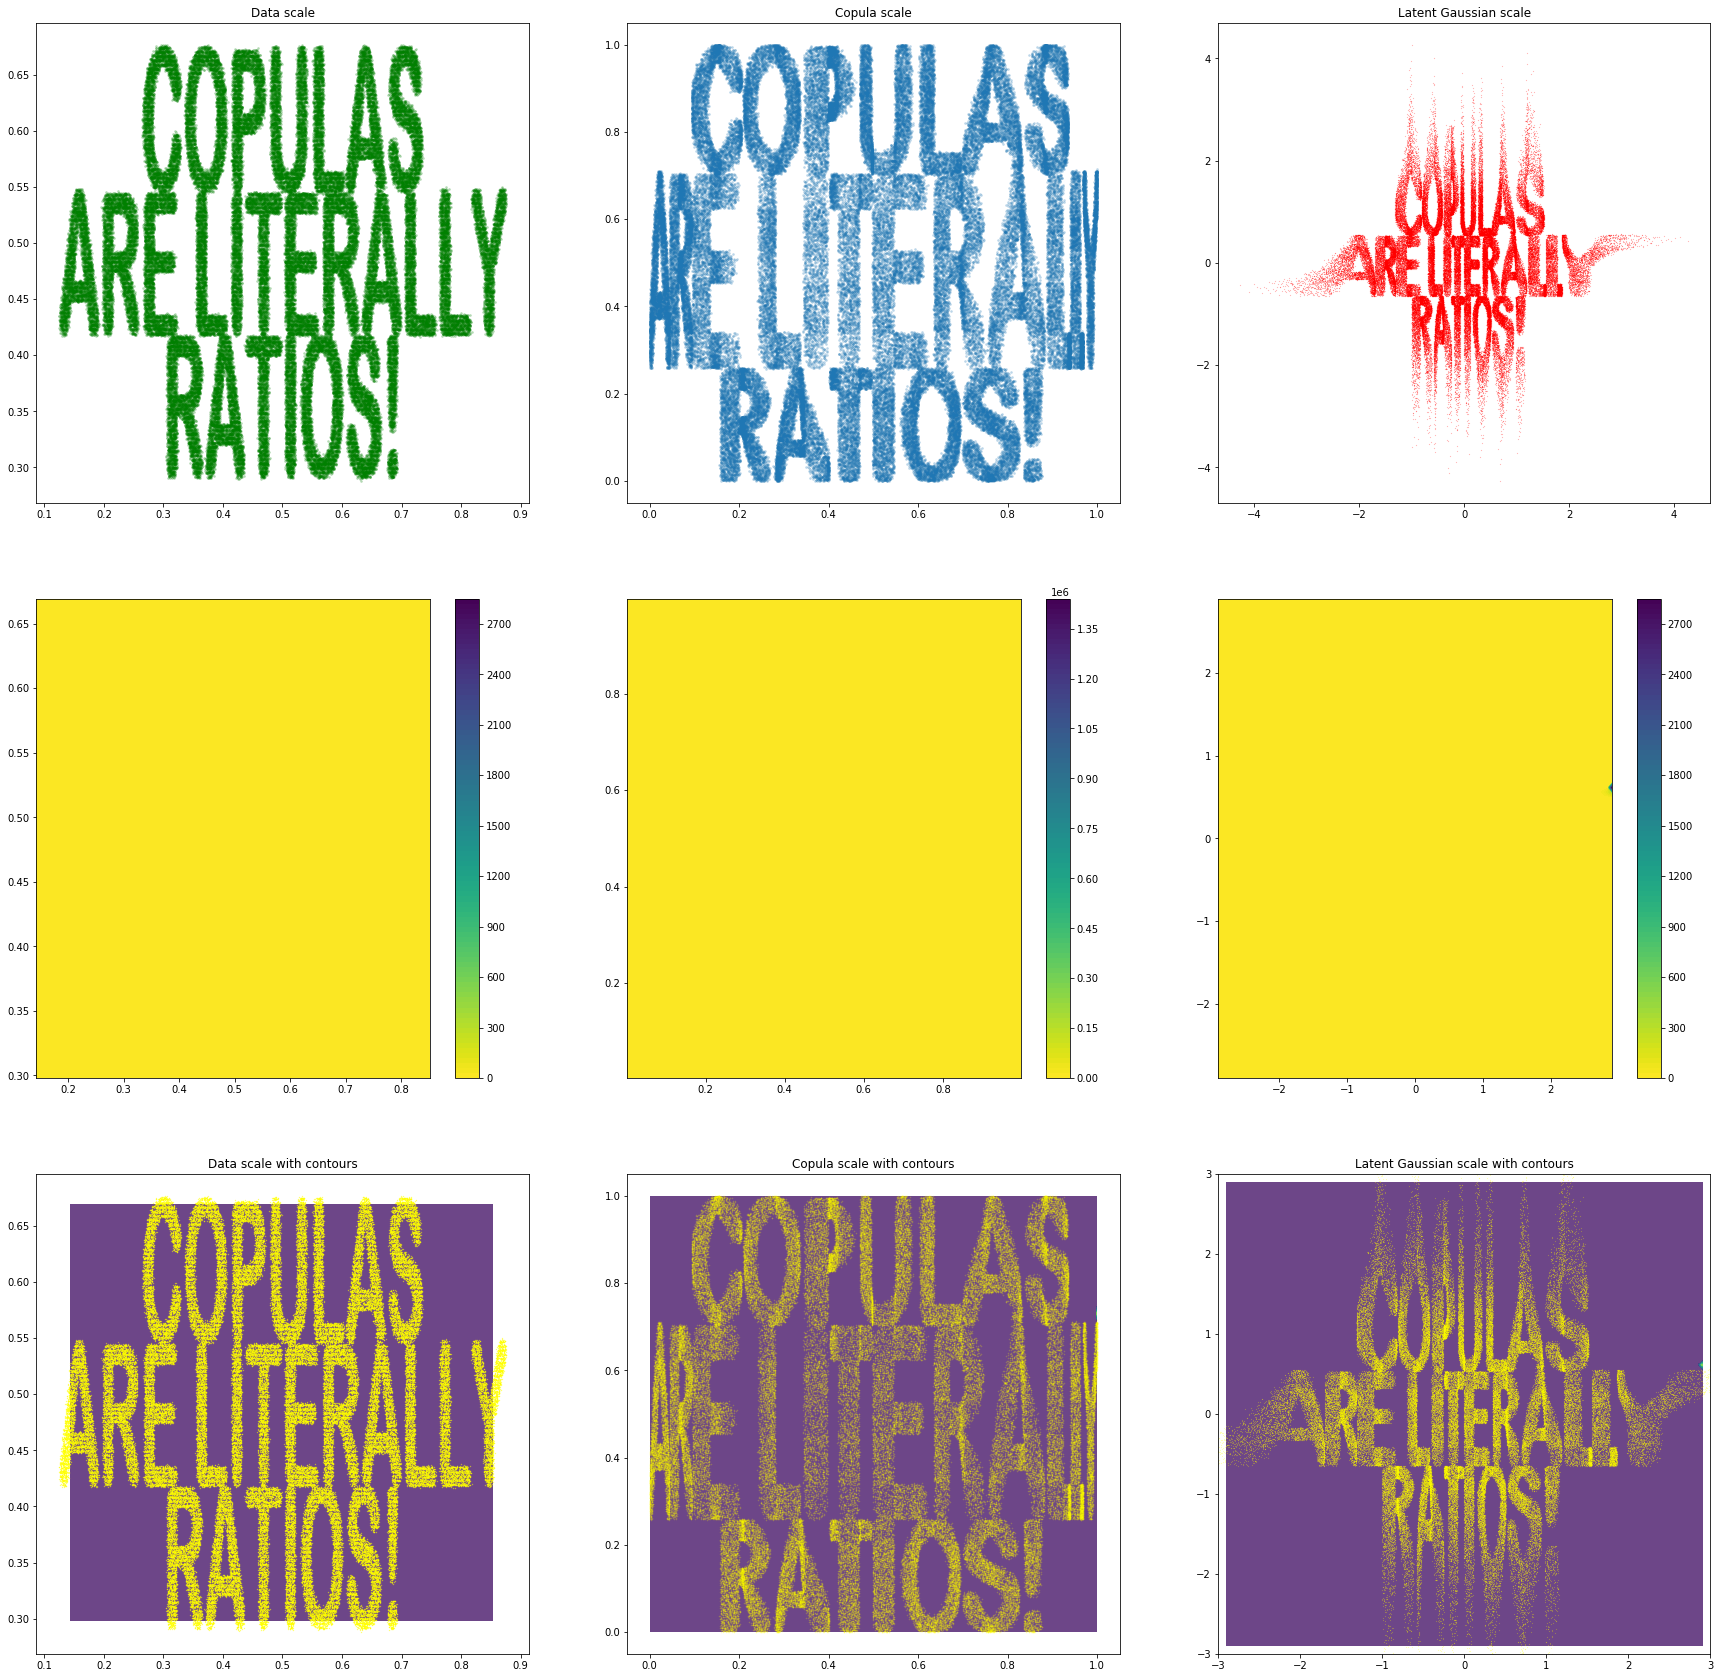

In [12]:
# Adjust the subplot configuration to 3 rows by 3 columns
fig, ax = plt.subplots(3, 3, figsize=(30, 30))  # Adjusted for 9 plots

# Original scatter plots
ax[0, 0].scatter(data_p[:,0], data_p[:,1], s=3, c='green', alpha=0.2)
ax[0, 1].scatter(u, v, s=3, alpha=0.2)
ax[0, 2].scatter(z1, z2, s=0.01, c='red')

# Titles for each scatter plot
ax[0, 0].set_title('Data scale')
ax[0, 1].set_title('Copula scale')
ax[0, 2].set_title('Latent Gaussian scale')

in_1 = np.clip(scs.norm.cdf(meshgrid[0]),a_max=0.99,a_min=0.01)
in_2 = np.clip(scs.norm.cdf(meshgrid[1]),a_max=0.99,a_min=0.01)

# Original contour plots with colorbars
contour_set = ax[1, 0].contourf(inverted_cdf1(in_1), inverted_cdf2(in_2), (gauss * ratio_grid).reshape(100, 100),levels=100,cmap='viridis_r')
fig.colorbar(contour_set, ax=ax[1, 0])
contour_set = ax[1, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), ( ratio_grid).reshape(100, 100),levels=100,cmap='viridis_r')
fig.colorbar(contour_set, ax=ax[1, 1])
contour_set = ax[1, 2].contourf(meshgrid[0], meshgrid[1], (gauss * ratio_grid).reshape(100, 100),levels=100,cmap='viridis_r')
fig.colorbar(contour_set, ax=ax[1, 2])

# Adding contour plots with scatter points on top in the third row
# For the first plot
ax[2, 0].contourf(inverted_cdf1(in_1), inverted_cdf2(in_2), (gauss * ratio_grid).reshape(100, 100), alpha=0.8)
ax[2, 0].scatter(data_p[:,0], data_p[:,1], s=0.1, c='yellow', alpha=0.8)
# For the second plot
ax[2, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), ( ratio_grid).reshape(100, 100), alpha=0.8)
ax[2, 1].scatter(u, v, s=0.4, alpha=0.2,c='yellow')
# For the third plot
ax[2, 2].contourf(meshgrid[0], meshgrid[1], (gauss * ratio_grid).reshape(100, 100), alpha=0.8)
ax[2, 2].scatter(z1, z2, s=0.01, c='yellow')
ax[2, 2].set_xlim(-3, 3)
ax[2, 2].set_ylim(-3, 3)
# Setting titles for the third row plots
ax[2, 0].set_title('Data scale with contours')
ax[2, 1].set_title('Copula scale with contours')
ax[2, 2].set_title('Latent Gaussian scale with contours')